In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="4"

# 3D example

Running simulations in 3D should be just as easy as adding an extra dimension to a 2D simulation script, where appropriate

In [1]:
from jax import numpy as jnp
import numpy as np

In [15]:
# Defining geometry
from jwave.geometry import kGrid, Medium

N = (128, 128, 128)
dx = (1., 1., 1.)
omega = 1

# Making geometry
grid = kGrid.make_grid(N, dx)

# Physical properties
sound_speed = jnp.ones(N)
sound_speed = sound_speed.at[30:90, 60:90, 60:90].set(1.7)
medium = Medium(
    sound_speed=sound_speed,
    density=1.,
    attenuation=0.0,
    pml_size=15
)

src_field = jnp.zeros(grid.N).astype(jnp.complex64)
src_field = src_field.at[32, 32, 32].set(10.0)

![](_images/3d_rectangle_sos.png)

In [16]:
from jwave.physics import solve_helmholtz

field = solve_helmholtz(
    grid, 
    medium, 
    src_field, 
    omega,
    method="bicgstab"
).block_until_ready()

Text(0.5, 1.0, 'Imaginary wavefield')

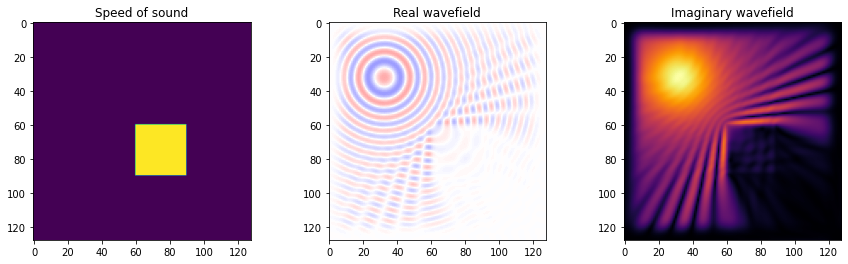

In [17]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots(1,3,figsize=(15,4))

axes[0].imshow(medium.sound_speed[50])
axes[0].set_title("Speed of sound")
axes[1].imshow(field.real[50], vmin=-.2, vmax=.2, cmap="seismic")
axes[1].set_title("Real wavefield")
axes[2].imshow(jnp.abs(field[50]), cmap="inferno")
axes[2].set_title("Imaginary wavefield")

In [18]:
import jax 

params, solver = solve_helmholtz(
    grid, 
    medium, 
    src_field, 
    omega,
    method="bicgstab",
    solve_problem=False
)

@jax.jit
def fast_solve(sos):
    new_medium = medium._replace(sound_speed=sos)
    params["medium"] = new_medium
    return solver(params)

In [19]:
field = fast_solve(medium.sound_speed)

In [20]:
%%timeit

solve_helmholtz(
    grid, 
    medium, 
    src_field, 
    omega,
    method="bicgstab"
).block_until_ready()

23 s ± 1.27 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
%%timeit

fast_solve(medium.sound_speed).block_until_ready()

20.4 s ± 899 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
